In [1]:
import os
import zipfile
import shutil
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
print(f"PyTorch Version: {torch.__version__}")
print(f"CUDA Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA Version: {torch.version.cuda}")
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")

Using device: cuda
PyTorch Version: 2.6.0+cu126
CUDA Available: True
CUDA Version: 12.6
GPU Name: NVIDIA GeForce RTX 2050


In [4]:
zip_file_path = "archive.zip"  # Update to your actual path
extract_dir = "./lung_colon_image_set"

def extract_dataset(zip_path, extract_to):
    os.makedirs(extract_to, exist_ok=True)
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        print(f"Extracting {zip_path} to {extract_to}...")
        zip_ref.extractall(extract_to)
    nested_dir = os.path.join(extract_to, 'lung_colon_image_set')
    if os.path.exists(nested_dir):
        for item in os.listdir(nested_dir):
            shutil.move(os.path.join(nested_dir, item), extract_to)
        os.rmdir(nested_dir)
    print("Extraction complete.")
    print("Final directory contents:", os.listdir(extract_to))

extract_dataset(zip_file_path, extract_dir)
data_dir = extract_dir

Extracting archive.zip to ./lung_colon_image_set...
Extraction complete.
Final directory contents: ['colon_image_sets', 'lung_image_sets']


In [8]:
IMG_SIZE = 160  # Input size for data loading
VIT_SIZE = 224  # Expected size for ViT-B/16
BATCH_SIZE = 2
ACCUMULATION_STEPS = 4  # Effective batch size = 8
NUM_CLASSES = 5
VALIDATION_SPLIT = 0.2
EPOCHS = 10
LEARNING_RATE = 2e-5
DROPOUT_RATE = 0.5

In [9]:
class LungColonDataset(Dataset):
    def __init__(self, dataset, class_map, transform=None):
        self.dataset = dataset
        self.class_map = class_map
        self.transform = transform
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        img, label = self.dataset[idx]
        unified_label = self.class_map[self.dataset.classes[label]]
        if self.transform:
            img = self.transform(img)
        return img, torch.tensor(unified_label, dtype=torch.long)

train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomRotation(30),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.7, 1.0)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

colon_dataset = datasets.ImageFolder(os.path.join(data_dir, 'colon_image_sets'))
lung_dataset = datasets.ImageFolder(os.path.join(data_dir, 'lung_image_sets'))

class_map = {
    'colon_aca': 0, 'colon_n': 1, 'lung_n': 2, 'lung_aca': 3, 'lung_scc': 4
}

colon_dataset_custom = LungColonDataset(colon_dataset, class_map, transform=train_transforms)
lung_dataset_custom = LungColonDataset(lung_dataset, class_map, transform=train_transforms)

def split_dataset(dataset, validation_split=VALIDATION_SPLIT):
    indices = list(range(len(dataset)))
    train_indices, val_indices = train_test_split(indices, test_size=validation_split, random_state=42)
    return Subset(dataset, train_indices), Subset(dataset, val_indices)

colon_train, colon_val = split_dataset(colon_dataset_custom)
lung_train, lung_val = split_dataset(lung_dataset_custom)

train_dataset = torch.utils.data.ConcatDataset([colon_train, lung_train])
val_dataset = torch.utils.data.ConcatDataset([colon_val, lung_val])

val_dataset.datasets[0].dataset.transform = val_transforms
val_dataset.datasets[1].dataset.transform = val_transforms

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

for inputs, labels in train_loader:
    print(f"Train batch - Inputs shape: {inputs.shape}, Labels shape: {labels.shape}")
    break
for inputs, labels in val_loader:
    print(f"Val batch - Inputs shape: {inputs.shape}, Labels shape: {labels.shape}")
    break

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")

Train batch - Inputs shape: torch.Size([2, 3, 160, 160]), Labels shape: torch.Size([2])
Val batch - Inputs shape: torch.Size([2, 3, 160, 160]), Labels shape: torch.Size([2])
Training samples: 20000
Validation samples: 5000


In [10]:
class ViT_Unet(nn.Module):
    def __init__(self, num_classes, dropout_rate=0.5):
        super(ViT_Unet, self).__init__()
        
        self.vit = models.vit_b_16(weights=models.ViT_B_16_Weights.IMAGENET1K_V1)
        self.vit.heads = nn.Identity()
        self.hidden_dim = 768
        self.num_patches = 196  # 224 / 16 = 14, 14 * 14 = 196 patches

        # Freeze ViT layers
        for param in self.vit.parameters():
            param.requires_grad = False

        # Resize layer to match ViT input
        self.resize = nn.Upsample(size=(VIT_SIZE, VIT_SIZE), mode='bilinear', align_corners=False)

        # Simplified U-Net with GELU
        self.up1 = nn.ConvTranspose2d(self.hidden_dim, 256, kernel_size=2, stride=2)
        self.conv1 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(256)
        self.gelu = nn.GELU()
        
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.resize(x)  # Resize from [batch, 3, 160, 160] to [batch, 3, 224, 224]
        patches = self.vit._process_input(x)  # [batch, 196, 768]
        batch_size = x.shape[0]
        cls_token = self.vit.class_token.expand(batch_size, -1, -1)
        x = torch.cat((cls_token, patches), dim=1)  # [batch, 197, 768]
        x = self.vit.encoder(x)  # [batch, 197, 768]
        x = x[:, 1:].transpose(1, 2).view(batch_size, self.hidden_dim, 14, 14)  # [batch, 768, 14, 14]

        x = self.up1(x)  # [batch, 256, 28, 28]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.gelu(x)
        
        x = self.global_pool(x)  # [batch, 256, 1, 1]
        x = x.view(x.size(0), -1)  # [batch, 256]
        x = self.dropout(x)
        x = self.fc(x)  # [batch, 5]
        return x

model = ViT_Unet(num_classes=NUM_CLASSES, dropout_rate=DROPOUT_RATE).to(device)

dummy_input = torch.randn(BATCH_SIZE, 3, IMG_SIZE, IMG_SIZE).to(device)
output = model(dummy_input)
print(f"Model test output shape: {output.shape}")

Model test output shape: torch.Size([2, 5])


In [11]:
import time
from torch.amp import GradScaler, autocast

def train_model(model, train_loader, val_loader, epochs=EPOCHS, learning_rate=LEARNING_RATE):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate, weight_decay=1e-2)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=2)
    scaler = GradScaler('cuda')

    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    best_val_loss = float('inf')
    patience = 3
    patience_counter = 0
    
    for epoch in range(epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        start_time = time.time()
        optimizer.zero_grad()
        for i, (inputs, labels) in enumerate(train_loader):
            batch_start = time.time()
            inputs, labels = inputs.to(device), labels.to(device)
            with autocast('cuda'):
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss = loss / ACCUMULATION_STEPS
            scaler.scale(loss).backward()
            
            if (i + 1) % ACCUMULATION_STEPS == 0:
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()
            
            running_loss += loss.item() * ACCUMULATION_STEPS
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            if i % 1000 == 999:
                print(f"Epoch {epoch+1}, Batch {i+1}/{len(train_loader)}, Time: {(time.time() - batch_start):.3f}s")
        
        if (i + 1) % ACCUMULATION_STEPS != 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
        
        train_loss = running_loss / len(train_loader)
        train_acc = correct / total
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        
        model.eval()
        val_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                with autocast('cuda'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        val_loss = val_loss / len(val_loader)
        val_acc = correct / total
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        scheduler.step(val_loss)
        
        epoch_time = time.time() - start_time
        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Time: {epoch_time:.2f}s")
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping triggered after {epoch+1} epochs")
                break
    
    return history

In [12]:
try:
    history = train_model(model, train_loader, val_loader)
    torch.save(model.state_dict(), 'vit_unet_lung_colon_10e.pth')
except Exception as e:
    print(f"An error occurred: {e}")

Epoch 1, Batch 1000/10000, Time: 0.101s
Epoch 1, Batch 2000/10000, Time: 0.102s
Epoch 1, Batch 3000/10000, Time: 0.098s
Epoch 1, Batch 4000/10000, Time: 0.096s
Epoch 1, Batch 5000/10000, Time: 0.100s
Epoch 1, Batch 6000/10000, Time: 0.100s
Epoch 1, Batch 7000/10000, Time: 0.095s
Epoch 1, Batch 8000/10000, Time: 0.098s
Epoch 1, Batch 9000/10000, Time: 0.100s
Epoch 1, Batch 10000/10000, Time: 0.112s
Epoch 1/10 - Train Loss: 0.7970, Train Acc: 0.7717, Val Loss: 0.1080, Val Acc: 0.9684, Time: 1294.54s
Epoch 2, Batch 1000/10000, Time: 0.093s
Epoch 2, Batch 2000/10000, Time: 0.089s
Epoch 2, Batch 3000/10000, Time: 0.105s
Epoch 2, Batch 4000/10000, Time: 0.095s
Epoch 2, Batch 5000/10000, Time: 0.092s
Epoch 2, Batch 6000/10000, Time: 0.093s
Epoch 2, Batch 7000/10000, Time: 0.094s
Epoch 2, Batch 8000/10000, Time: 0.095s
Epoch 2, Batch 9000/10000, Time: 0.097s
Epoch 2, Batch 10000/10000, Time: 0.096s
Epoch 2/10 - Train Loss: 0.6051, Train Acc: 0.8375, Val Loss: 0.0889, Val Acc: 0.9758, Time: 120

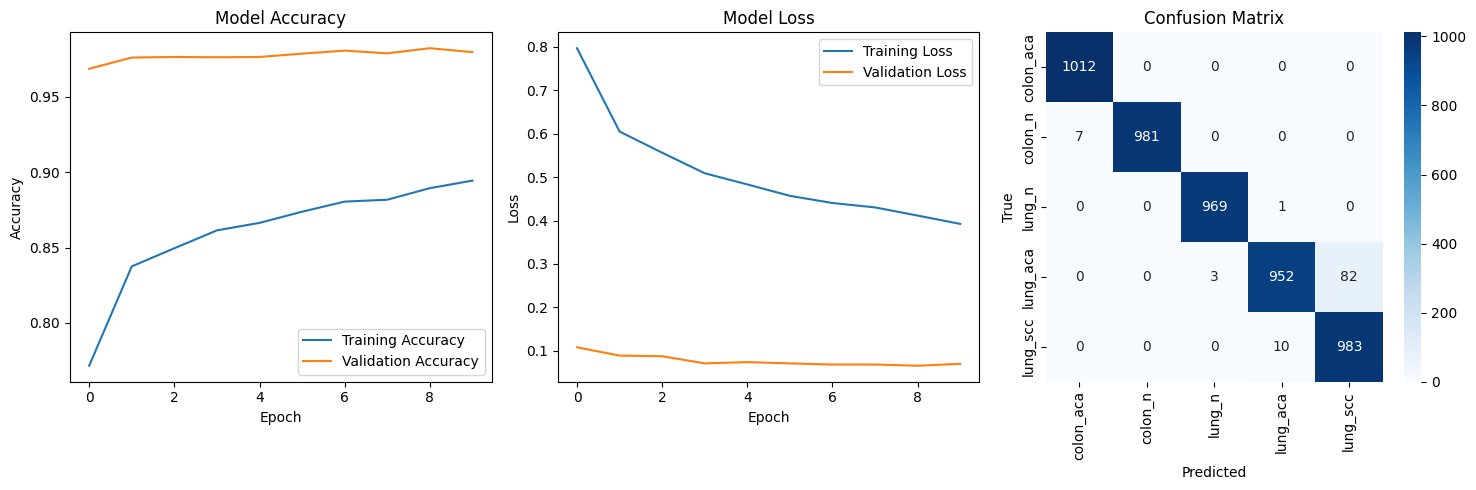

In [13]:
def get_predictions(model, val_loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return all_preds, all_labels

val_preds, val_labels = get_predictions(model, val_loader, device)

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(history['train_acc'], label='Training Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(history['train_loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

cm = confusion_matrix(val_labels, val_preds)
class_names = ['colon_aca', 'colon_n', 'lung_n', 'lung_aca', 'lung_scc']
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, ax=plt.subplot(1, 3, 3))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.tight_layout()
plt.show()

Classification Report:
               precision    recall  f1-score   support

   colon_aca       0.99      1.00      1.00      1012
     colon_n       1.00      0.99      1.00       988
      lung_n       1.00      1.00      1.00       970
    lung_aca       0.99      0.92      0.95      1037
    lung_scc       0.92      0.99      0.96       993

    accuracy                           0.98      5000
   macro avg       0.98      0.98      0.98      5000
weighted avg       0.98      0.98      0.98      5000



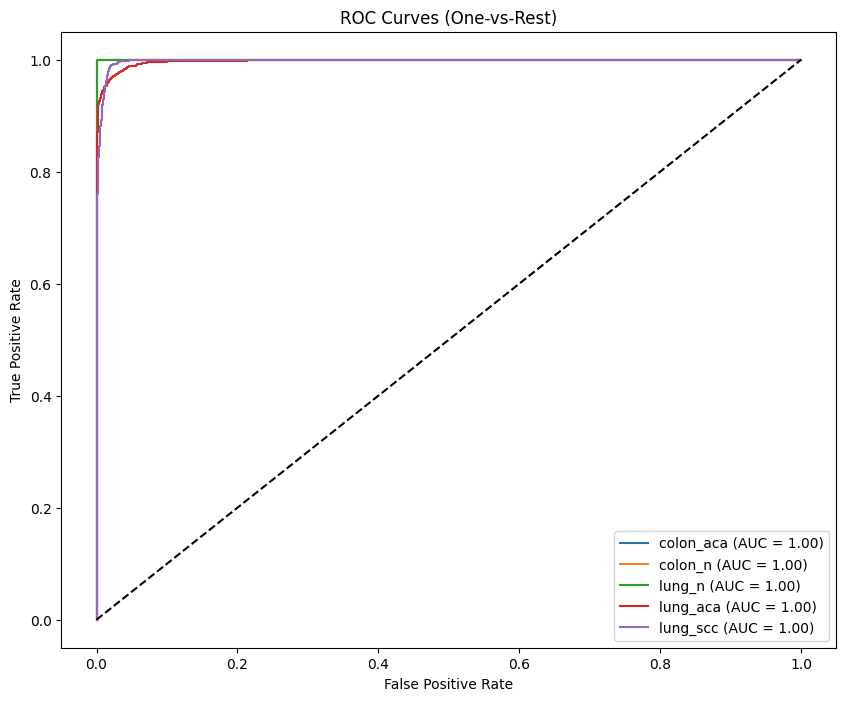

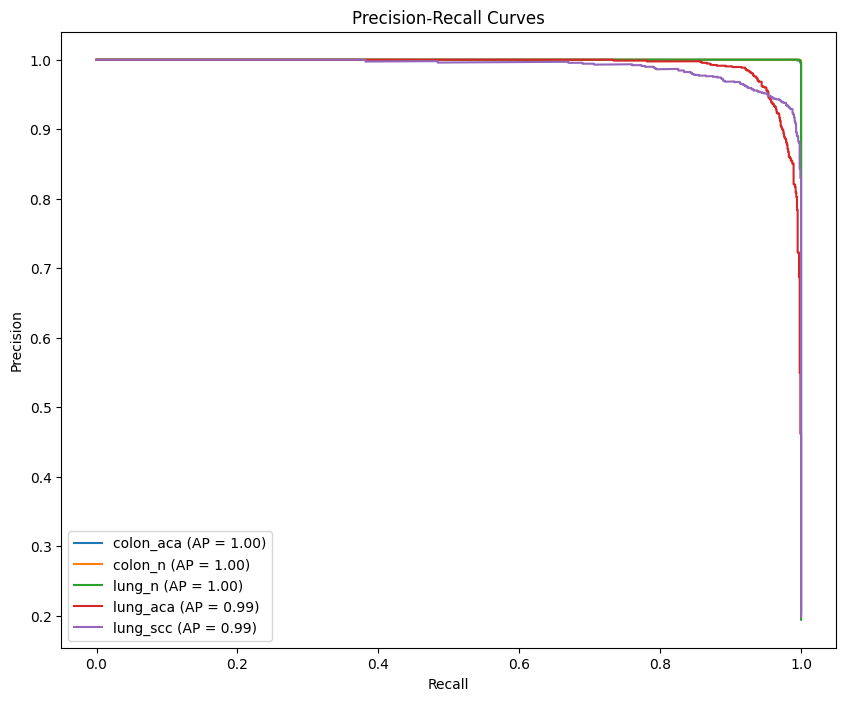

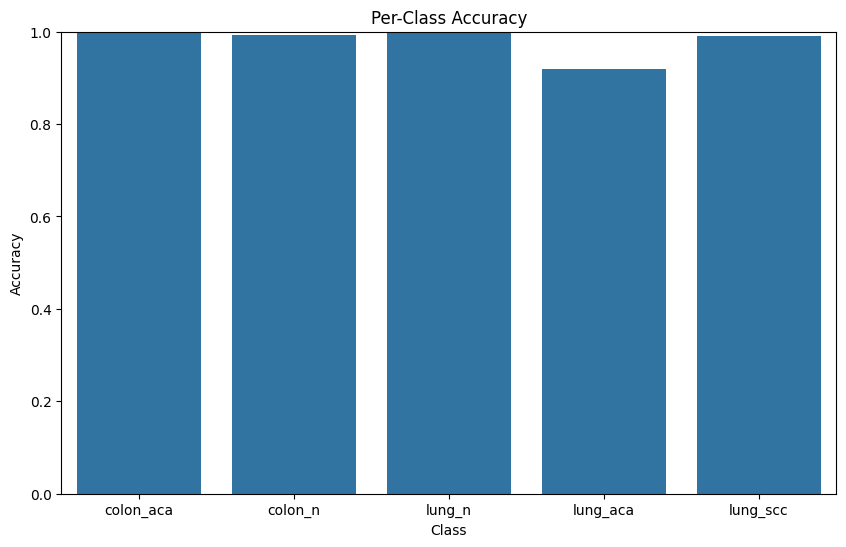

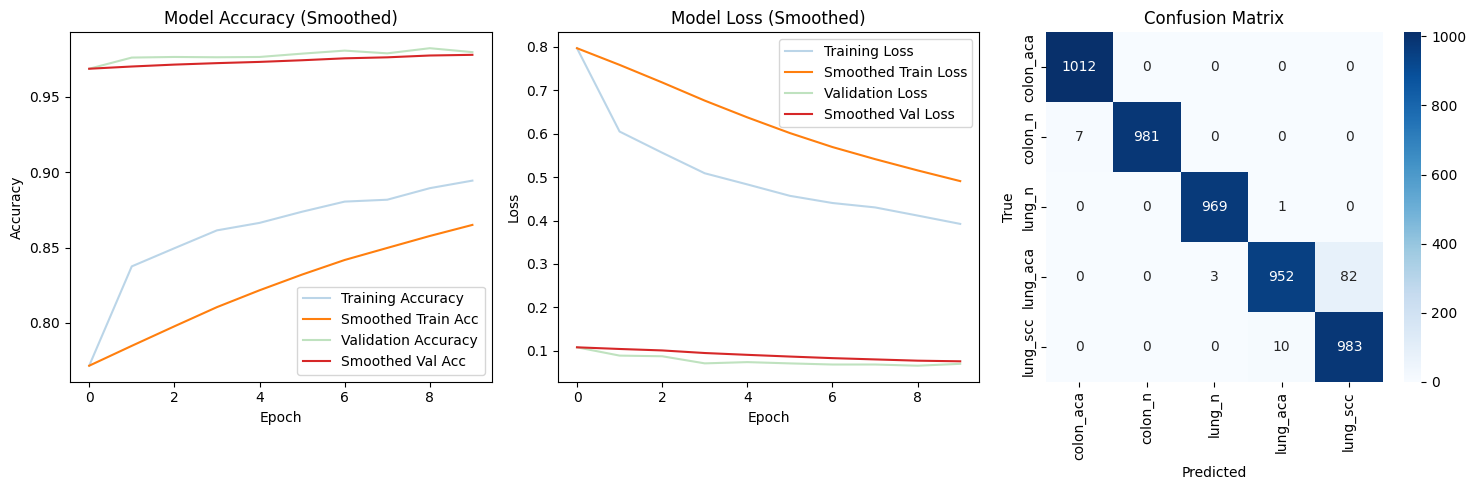

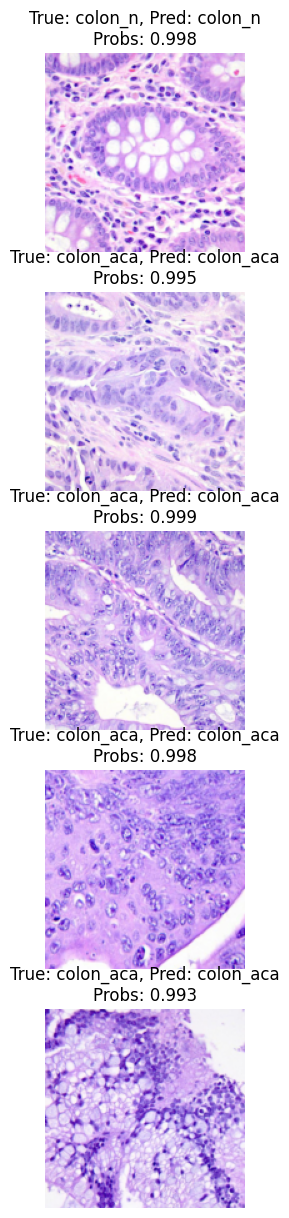

In [15]:
import numpy as np
from sklearn.metrics import classification_report, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize
from collections import Counter

def get_predictions(model, val_loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return all_preds, all_labels

def get_probabilities(model, val_loader, device):
    model.eval()
    all_probs = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)
            all_probs.append(probs.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
    return np.concatenate(all_probs), np.concatenate(all_labels)

def smooth_curve(points, factor=0.8):
    smoothed = [points[0]]
    for point in points[1:]:
        smoothed.append(smoothed[-1] * factor + point * (1 - factor))
    return smoothed

def show_sample_predictions(model, val_loader, device, num_samples=5):
    model.eval()
    images, true_labels, pred_labels, probs = [], [], [], []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            probs_batch = torch.softmax(outputs, dim=1)
            _, preds = torch.max(probs_batch, 1)
            images.extend(inputs.cpu()[:num_samples])
            true_labels.extend(labels.cpu()[:num_samples])
            pred_labels.extend(preds.cpu()[:num_samples])
            probs.extend(probs_batch.cpu()[:num_samples])
            if len(images) >= num_samples:
                break
    
    plt.figure(figsize=(15, 3 * num_samples))
    for i in range(num_samples):
        img = images[i].permute(1, 2, 0).numpy() * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img = np.clip(img, 0, 1)
        plt.subplot(num_samples, 1, i+1)
        plt.imshow(img)
        plt.title(f"True: {class_names[true_labels[i]]}, Pred: {class_names[pred_labels[i]]}\nProbs: {probs[i].max():.3f}")
        plt.axis('off')
    plt.show()

val_preds, val_labels = get_predictions(model, val_loader, device)
val_probs, val_labels = get_probabilities(model, val_loader, device)
val_labels_bin = label_binarize(val_labels, classes=range(NUM_CLASSES))
class_names = ['colon_aca', 'colon_n', 'lung_n', 'lung_aca', 'lung_scc']

# 1. Classification Report
print("Classification Report:\n", classification_report(val_labels, val_preds, target_names=class_names))

# 2. ROC Curves
plt.figure(figsize=(10, 8))
for i in range(NUM_CLASSES):
    fpr, tpr, _ = roc_curve(val_labels_bin[:, i], val_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{class_names[i]} (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves (One-vs-Rest)')
plt.legend(loc='lower right')
plt.show()

# 3. Precision-Recall Curves
plt.figure(figsize=(10, 8))
for i in range(NUM_CLASSES):
    precision, recall, _ = precision_recall_curve(val_labels_bin[:, i], val_probs[:, i])
    ap = average_precision_score(val_labels_bin[:, i], val_probs[:, i])
    plt.plot(recall, precision, label=f'{class_names[i]} (AP = {ap:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend(loc='lower left')
plt.show()

# 4. Per-Class Accuracy
cm = confusion_matrix(val_labels, val_preds)
per_class_acc = cm.diagonal() / cm.sum(axis=1)
plt.figure(figsize=(10, 6))
sns.barplot(x=class_names, y=per_class_acc)
plt.title('Per-Class Accuracy')
plt.xlabel('Class')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.show()

# 5. Smoothed Loss/Accuracy Curves
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(history['train_acc'], label='Training Accuracy', alpha=0.3)
plt.plot(smooth_curve(history['train_acc']), label='Smoothed Train Acc')
plt.plot(history['val_acc'], label='Validation Accuracy', alpha=0.3)
plt.plot(smooth_curve(history['val_acc']), label='Smoothed Val Acc')
plt.title('Model Accuracy (Smoothed)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(history['train_loss'], label='Training Loss', alpha=0.3)
plt.plot(smooth_curve(history['train_loss']), label='Smoothed Train Loss')
plt.plot(history['val_loss'], label='Validation Loss', alpha=0.3)
plt.plot(smooth_curve(history['val_loss']), label='Smoothed Val Loss')
plt.title('Model Loss (Smoothed)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Confusion Matrix (original)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, ax=plt.subplot(1, 3, 3))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

# 6. Sample Predictions
show_sample_predictions(model, val_loader, device)
